<a href="https://colab.research.google.com/github/toraaglobal/CaseStudies/blob/master/time_series_api_quandi_stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# SEt environment Variable
import os

#os.environ['QUANDI_API_KEY']=''

In [0]:
#!export | grep QUANDI
!pip install quandl

  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [0]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

import quandl

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from scipy.stats import boxcox


plt.style.use('fivethirtyeight')

%matplotlib inline

In [0]:


# Data from quandi API. returns a numpy array
quandl.ApiConfig.api_key = os.environ.get('QUANDI_API_KEY')

data = quandl.get('NASDAQOMX/XQC', start_date='2017-04-30', end_date='2019-04-29', returns="numpy")

In [0]:
data[:20]

rec.array([('2017-05-01T00:00:00.000000000', 5629.63, 0., 0., 0., 0.),
           ('2017-05-02T00:00:00.000000000', 5644.07, 0., 0., 0., 0.),
           ('2017-05-03T00:00:00.000000000', 5625.16, 0., 0., 0., 0.),
           ('2017-05-04T00:00:00.000000000', 5626.32, 0., 0., 0., 0.),
           ('2017-05-05T00:00:00.000000000', 5646.09, 0., 0., 0., 0.),
           ('2017-05-08T00:00:00.000000000', 5659.07, 0., 0., 0., 0.),
           ('2017-05-09T00:00:00.000000000', 5678.31, 0., 0., 0., 0.),
           ('2017-05-10T00:00:00.000000000', 5681.68, 0., 0., 0., 0.),
           ('2017-05-11T00:00:00.000000000', 5674.22, 0., 0., 0., 0.),
           ('2017-05-12T00:00:00.000000000', 5686.81, 0., 0., 0., 0.),
           ('2017-05-15T00:00:00.000000000', 5704.48, 0., 0., 0., 0.),
           ('2017-05-16T00:00:00.000000000', 5724.44, 0., 0., 0., 0.),
           ('2017-05-17T00:00:00.000000000', 5580.55, 0., 0., 0., 0.),
           ('2017-05-18T00:00:00.000000000', 5626.31, 0., 0., 0., 0.),
      

In [0]:
datadf = pd.DataFrame(data)  

print(datadf.describe())

       Index Value   High    Low  Total Market Value  Dividend Market Value
count   501.000000  501.0  501.0               501.0                  501.0
mean   6669.601477    0.0    0.0                 0.0                    0.0
std     595.083758    0.0    0.0                 0.0                    0.0
min    5580.550000    0.0    0.0                 0.0                    0.0
25%    6114.350000    0.0    0.0                 0.0                    0.0
50%    6737.140000    0.0    0.0                 0.0                    0.0
75%    7131.120000    0.0    0.0                 0.0                    0.0
max    7826.680000    0.0    0.0                 0.0                    0.0


In [0]:
datadf.head()

,Trade Date,Index Value,High,Low,Total Market Value,Dividend Market Value
0,2017-05-01,5629.63,0.0,0.0,0.0,0.0
1,2017-05-02,5644.07,0.0,0.0,0.0,0.0
2,2017-05-03,5625.16,0.0,0.0,0.0,0.0
3,2017-05-04,5626.32,0.0,0.0,0.0,0.0
4,2017-05-05,5646.09,0.0,0.0,0.0,0.0


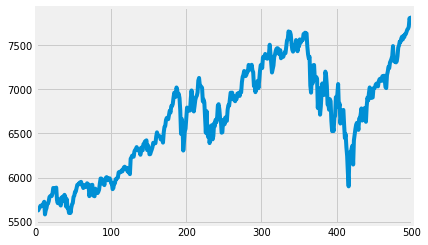

In [0]:
datadf['Index Value'].plot()
plt.show()


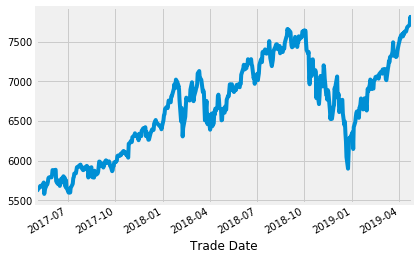

In [0]:
# create a series

series = pd.Series(datadf['Index Value'].values, index=datadf['Trade Date'])

series.plot()
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


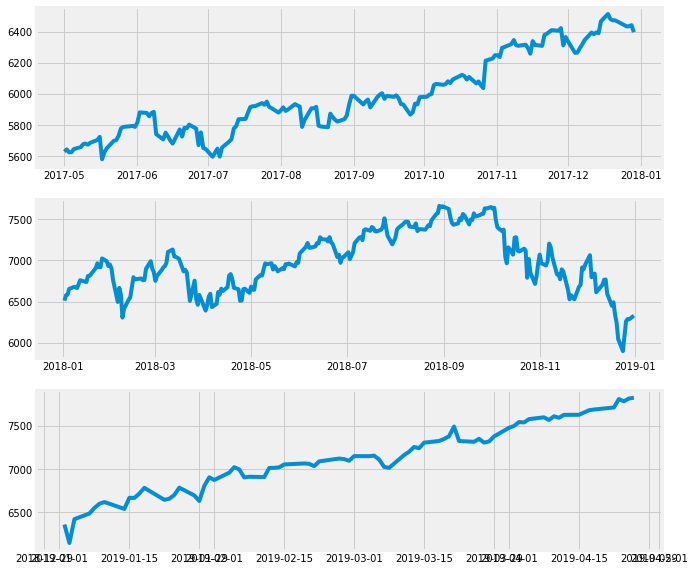

Empty DataFrame
Columns: []
Index: []


In [0]:
#group plot with years

groups = series.groupby(pd.TimeGrouper('A'))

years = pd.DataFrame()

plt.figure(figsize = (10,10))

n_groups = len(groups)
i = 1

for name, group in groups:
  plt.subplot((n_groups * 100) + 10 + i)
  i +=1
  plt.plot(group)
  
plt.show()
print(years)
print(groups)

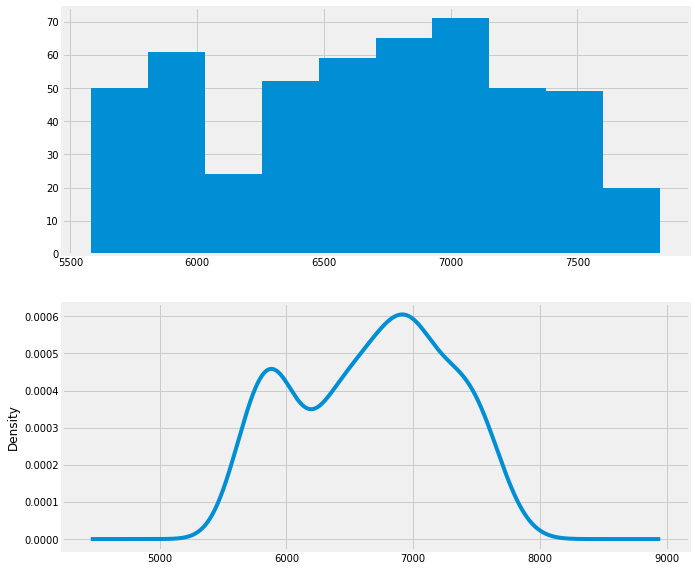

In [0]:
# histograme

plt.figure(figsize = (10,10))
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

In [0]:
# helper function


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff



# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		weeks_in_year = 52
		diff = difference(history, weeks_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, weeks_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse





# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [0]:
# create train and text split

# CREATE TRAIN-TEST DATA


split_point = len(series) - 100

dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 401, Validation 100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [0]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)

train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=6714.196, Expected=6656
>Predicted=6686.547, Expected=6606
>Predicted=6748.367, Expected=6682
>Predicted=6817.265, Expected=6644
>Predicted=6632.934, Expected=6643
>Predicted=6676.770, Expected=6769
>Predicted=6740.633, Expected=6822
>Predicted=6802.798, Expected=6815
>Predicted=6938.321, Expected=6893
>Predicted=6988.862, Expected=6964
>Predicted=6885.007, Expected=6953
>Predicted=6908.165, Expected=6964
>Predicted=6845.661, Expected=6889
>Predicted=6938.580, Expected=6930
>Predicted=6995.928, Expected=6902
>Predicted=6938.972, Expected=6866
>Predicted=6900.694, Expected=6906
>Predicted=6953.564, Expected=6894
>Predicted=7025.516, Expected=6954
>Predicted=6993.206, Expected=6950
>Predicted=6878.175, Expected=6961
>Predicted=6959.473, Expected=6927
>Predicted=6900.735, Expected=6976
>Predicted=6968.891, Expected=6968
>Predicted=6802.646, Expected=7084
>Predicted=7099.019, Expected=7144
>Predicted=7068.196, Expected=7167
>Predicted=6989.490, Expected=7210
>Predicted=7027.431,

In [0]:
## CODE FROM BROWNLEE FOR SAVING MODEL

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__


# prepare data
X = series.values
X = X.astype('float32')
# difference data
weeks_in_year = 52
diff = difference(X, weeks_in_year)
# fit model
model = ARIMA(diff, order=(2,0,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


>Predicted=8389.983, Expected=7062
>Predicted=7065.329, Expected=6795
>Predicted=6907.030, Expected=6839
>Predicted=6821.636, Expected=6613
>Predicted=6662.177, Expected=6683
>Predicted=6715.316, Expected=6704
>Predicted=6724.260, Expected=6764
>Predicted=6846.836, Expected=6768
>Predicted=6789.508, Expected=6595
>Predicted=6643.334, Expected=6448
>Predicted=6460.830, Expected=6492
>Predicted=6519.888, Expected=6343
>Predicted=6224.848, Expected=6243
>Predicted=6170.961, Expected=6047
>Predicted=6026.365, Expected=5899
>Predicted=5942.714, Expected=6263
>Predicted=5936.927, Expected=6288
>Predicted=6219.059, Expected=6285
>Predicted=6494.140, Expected=6330
>Predicted=6263.103, Expected=6361
>Predicted=6583.244, Expected=6147
>Predicted=6187.194, Expected=6423
>Predicted=6263.561, Expected=6488
>Predicted=6485.639, Expected=6552
>Predicted=6597.373, Expected=6601
>Predicted=6591.511, Expected=6621
>Predicted=6302.715, Expected=6601
>Predicted=6823.370, Expected=6541
>Predicted=6405.413,

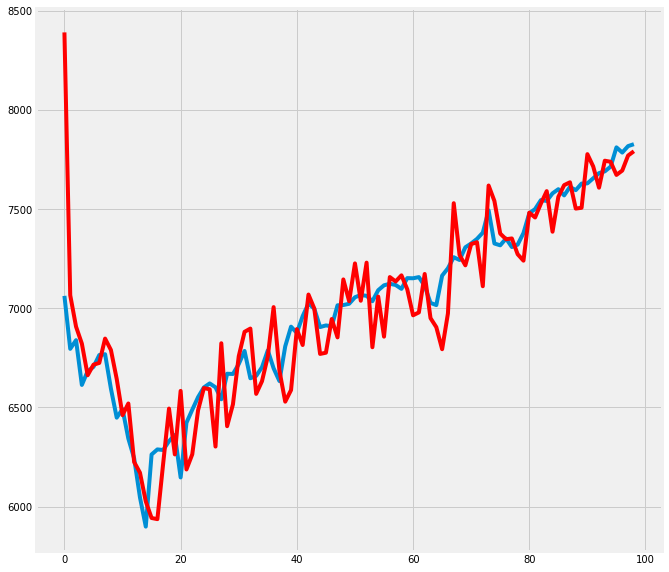

In [0]:
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD

 
# prepare datasets

X = dataset.values.astype('float32')
history = [x for x in X]
weeks_in_year = 52
validation = pd.Series.from_csv('validation.csv', header=0)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, weeks_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

plt.figure(figsize=(10,10))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(2,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

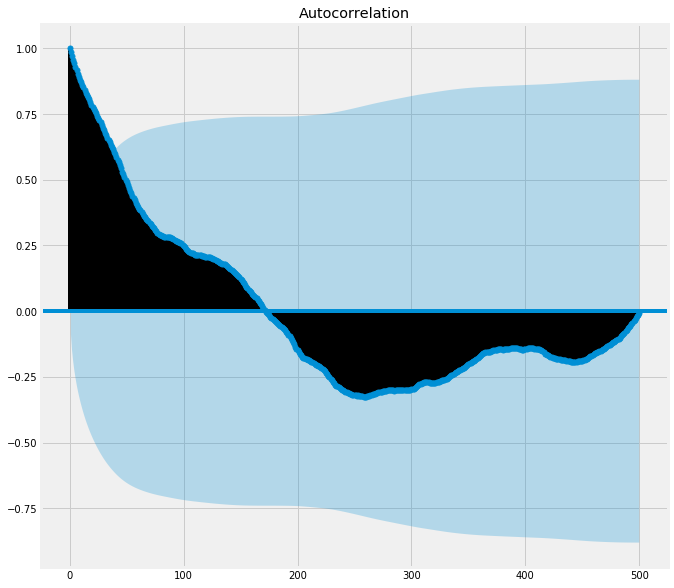

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


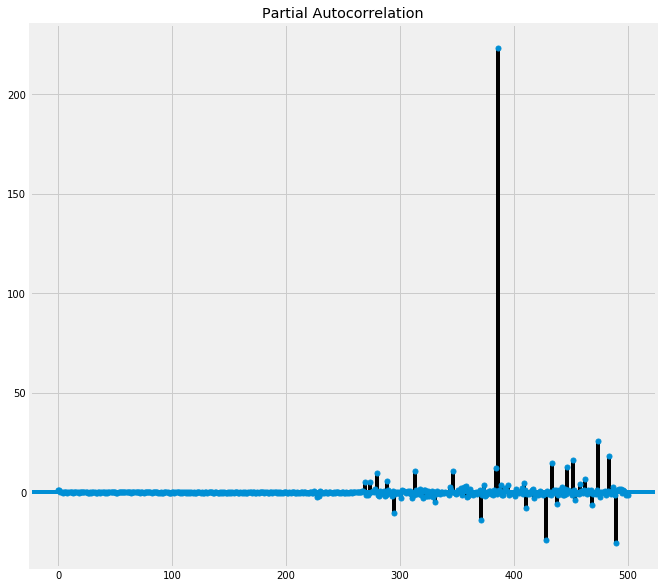

In [0]:

plt.figure(figsize=(10,10))
plot_acf(series, ax=plt.gca())
plt.show()

#pyplot.subplot(212)

plt.figure(figsize=(10,10))
plot_pacf(series, ax=plt.gca())
plt.show()